# Modeling Bordeaux Wine Auction Prices Using Linear Regression

This project models historical Bordeaux wine auction prices using climate variables 
and winery characteristics. The goal is to build an interpretable and predictive 
model using statistical regression techniques, evaluate it using out-of-sample R², 
and improve model accuracy through multicollinearity diagnostics (VIF).


In [1]:
# Imports

from statsmodels.stats.outliers_influence import variance_inflation_factor

## 1. Load Data and Explore Structure

We begin by loading the aggregated wine dataset (wine_agg.csv), which contains 
annual climate conditions, wine age, and auction index values.


In [1]:
import pandas as pd

# Assumes wine_agg.csv is in the same directory as this notebook/script
wine = pd.read_csv("wine_agg.csv")

# Quick structure check
print(wine.info())
wine.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Year             46 non-null     int64  
 1   LogAuctionIndex  46 non-null     float64
 2   WinterRain       46 non-null     float64
 3   HarvestRain      46 non-null     float64
 4   GrowTemp         46 non-null     float64
 5   HarvestTemp      46 non-null     float64
 6   Age              46 non-null     int64  
 7   FrancePop        46 non-null     float64
 8   USAlcConsump     46 non-null     float64
dtypes: float64(7), int64(2)
memory usage: 3.4 KB
None


,Year,LogAuctionIndex,WinterRain,HarvestRain,GrowTemp,HarvestTemp,Age,FrancePop,USAlcConsump
0,1952,7.4950,566.4,165.5,17.28,14.39,63,42.46,7.85
1,1953,8.0393,653.3,75.6,16.94,17.64,62,42.75,8.03
2,1955,7.6858,504.3,129.5,17.30,17.13,60,43.43,7.84
3,1957,6.9845,390.8,110.4,16.31,16.47,58,44.31,7.77
4,1958,6.7772,538.8,187.0,16.82,19.72,57,44.79,7.74


## 2. Exploratory Data Analysis

We examine the distribution of LogAuctionIndex, which is already log-transformed 
in the dataset, and compute correlations among predictors.


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


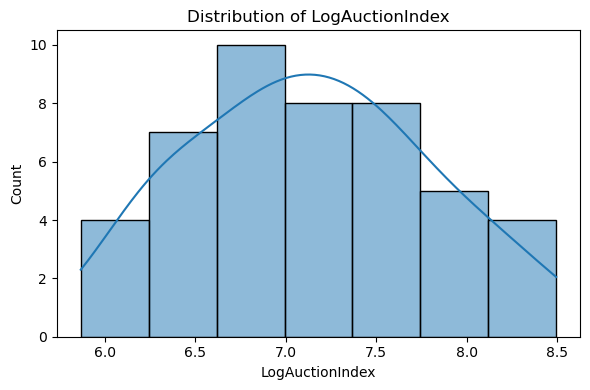

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns


# Check distribution of the dependent variable (already log-transformed)
plt.figure(figsize=(6,4))
sns.histplot(wine["LogAuctionIndex"], kde=True)
plt.title("Distribution of LogAuctionIndex")
plt.xlabel("LogAuctionIndex")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## Correlation Analysis

Before fitting any regression models, we examine the correlations among the key variables.
This helps us understand potential linear relationships as well as early signs of 
multicollinearity. A correlation matrix provides a quick overview of how climate
factors, age, and population variables relate to the wine auction index.


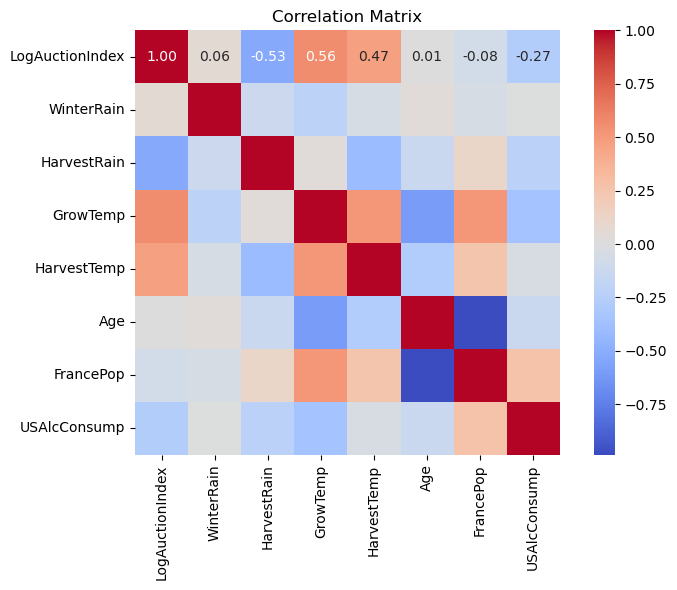

In [5]:
# Correlation matrix of main variables
plt.figure(figsize=(8,6))
corr = wine[["LogAuctionIndex","WinterRain","HarvestRain",
             "GrowTemp","HarvestTemp","Age","FrancePop","USAlcConsump"]].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

## Model Prep. Train/Test Split (Chronological)

Following good forecasting practice, we split the dataset chronologically: 
wines before 1985 are used for training, and wines after 1985 for testing. Setting aside the most recently observed data for the  test set.


In [6]:
#  Chronological train/test split:
#  Use years <= 1985 for training, > 1985 for testing
wine_train = wine[wine["Year"] <= 1985].copy()
wine_test  = wine[wine["Year"] > 1985].copy()

len(wine_train), len(wine_test)

(31, 15)

## 4. Baseline Regression Model

We begin with a full model including all available predictors:
WinterRain, HarvestRain, GrowTemp, HarvestTemp, Age, FrancePop, USAlcConsump.

In [13]:
import statsmodels.formula.api as smf

# Initial model with more predictors
formula_full = "LogAuctionIndex ~ WinterRain + HarvestRain + GrowTemp + HarvestTemp + Age + FrancePop + USAlcConsump"

model = smf.ols(formula=formula_full, data=wine_train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        LogAuctionIndex   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                     12.31
Date:                Fri, 19 Dec 2025   Prob (F-statistic):           1.86e-06
Time:                        12:46:46   Log-Likelihood:                -5.0600
No. Observations:                  31   AIC:                             26.12
Df Residuals:                      23   BIC:                             37.59
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -4.9663      9.382     -0.529   

## 5. OSR² & VIF Diagnostics for the Full Model

### Out-of-Sample R² 
 
To evaluate how well the full regression model generalizes to new data, 
we compute the Out-of-Sample R². Unlike the standard R², which 
measures goodness-of-fit on the training data, OSR² evaluates predictive 
performance on the test set—data the model has never seen before.
 
The OSR² metric compares:
- the model’s squared prediction errors on the test set (SSE), against
- a naive baseline model that always predicts the **mean** of the training 
  LogAuctionIndex (SST).
 
 
A higher OSR² indicates stronger predictive ability.  
We apply OSR² to the full model below to obtain its out-of-sample performance.

### VIF
 
We will remove predictors with high VIF and/or low statistical significance 
to improve model stability and predictive accuracy. VIF quantifies how much 
the variance of each coefficient is inflated due to correlations with 
other predictors.  We will start with FrancePop.
 
Interpretation guidelines:
- VIF < 5  : low multicollinearity
- VIF 5–10 : moderate multicollinearity (potential concern)
- VIF > 10 : high multicollinearity (problematic)


Such extreme multicollinearity:
- inflates standard errors,
- destabilizes coefficient estimates,
- reduces statistical significance,
- and harms predictive performance.

 
If VIF values remain high, further variable removal may be required to 
improve model stability and interpretability.

In [16]:
import numpy as np

# Out-of-sample R-squared (OSR2)

def OSR2(model, df_train, df_test, dependent_var):
    
    # Actual y values in test set
    y_test = df_test[dependent_var]
    
    # Model predictions on test set
    y_pred = model.predict(df_test)
    
    # Sum of squared errors on test set
    SSE = np.sum((y_test - y_pred)**2)
    
    # Baseline: predict the mean of training y for all test observations
    y_train_mean = df_train[dependent_var].mean()
    SST = np.sum((y_test - y_train_mean)**2)
    
    return 1 - SSE/SST

In [17]:
OSR2(model, wine_train, wine_test, 'LogAuctionIndex')

0.5377506779454967

### Interpretation of OSR² for Full Model
 
The full model achieves an Out-of-Sample R² (OSR²) of **0.538**, meaning it 
explains approximately **53.8%** of the variation in LogAuctionIndex for 
new, unseen wine data.
 
This indicates that the model does have some predictive power, but its 
performance drops noticeably compared to the in-sample R² of **0.789**. 
Such a gap suggests that the full model may be overfitting the training 
data—capturing noise rather than true signal—possibly due to the inclusion 
of highly collinear or non-informative predictors (e.g., FrancePop, 
USAlcConsump, HarvestTemp).
 
The moderate OSR² provides motivation to refine the model by:
- removing predictors with high Variance Inflation Factors (VIF),
- eliminating variables with weak statistical significance,
- simplifying the model structure to improve generalization.
 
In the next sections, we perform systematic model refinement to improve 
both stability and out-of-sample predictive performance.

In [32]:
# Calculate Variance Inflation Factor for each explanatory variable
 
from statsmodels.stats.outliers_influence import variance_inflation_factor
 
def VIF(df, columns):
    
    values = sm.add_constant(df[columns]).values  # the dataframe passed to VIF must include the intercept term. We add it the same way we did before.
    num_columns = len(columns)+1
    vif = [variance_inflation_factor(values, i) for i in range(num_columns)]
    
    return pd.Series(vif[1:], index=columns)

In [33]:
import statsmodels.api as sm

# VIF for full model
cols_full = ["WinterRain","HarvestRain","GrowTemp","HarvestTemp","Age","FrancePop","USAlcConsump"]
VIF(wine_train, cols_full)

WinterRain       1.295370
HarvestRain      1.578682
GrowTemp         1.700079
HarvestTemp      2.198191
Age             66.936256
FrancePop       81.792302
USAlcConsump    10.441217
dtype: float64

### Interpretation of VIF for Full Model
Age, FrancePop, and USAlcConsump show extremely high values, indicating strong redundancy and are likely driven by shared time trends. This multicollinearity inflates standard errors and destabilizes coefficient estimates, contributing to overfitting and weaker out-of-sample performance. We will simplify the model by removing these predictors.

## 6.1 Model Refinement Step 1 — Remove FrancePop

The full model exhibited severe multicollinearity, particularly among the 
time-related variables (Age, FrancePop, and Year). FrancePop displayed one 
of the highest Variance Inflation Factors (VIF > 80), indicating that it was 
almost perfectly correlated with Age and Year.

To improve model stability and interpretability, we remove FrancePop and 
refit the regression model below.


In [36]:
# Remove FrancePop

model2 = smf.ols(formula='LogAuctionIndex ~ WinterRain + HarvestRain + GrowTemp + HarvestTemp + Age + USAlcConsump',
                 data=wine_train).fit()

print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:        LogAuctionIndex   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     14.95
Date:                Fri, 19 Dec 2025   Prob (F-statistic):           4.60e-07
Time:                        13:01:00   Log-Likelihood:                -5.0902
No. Observations:                  31   AIC:                             24.18
Df Residuals:                      24   BIC:                             34.22
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -6.8405      3.071     -2.228   

In [38]:
VIF(wine_train, ['WinterRain', 'HarvestRain', 'GrowTemp', 'HarvestTemp', 'Age','USAlcConsump'])

WinterRain      1.223155
HarvestRain     1.509070
GrowTemp        1.500905
HarvestTemp     2.122007
Age             8.580764
USAlcConsump    8.350251
dtype: float64

### Interpretation of VIF After Removing FrancePop

The updated VIF values show that multicollinearity has been reduced 
substantially compared to the full model. The climate variables 
(WinterRain, HarvestRain, GrowTemp, HarvestTemp) all have VIF values 
below 3, indicating little to no multicollinearity.

However, two variables still exhibit elevated VIF:
- **Age (VIF ≈ 8.58)**
- **USAlcConsump (VIF ≈ 8.35)**

VIF values above 5 suggest moderate-to-high multicollinearity, and values 
approaching 10 indicate that the variable may be strongly correlated with 
other predictors. Age and USAlcConsump both track time changes across the 
dataset, which explains their strong linear relationships with one another 
and with other time-related variables.

This result indicates that additional refinement is war


### 6.2 Model Refinement Step 2 — Remove USAlcConsump

Although removing FrancePop substantially reduced multicollinearity, the 
previous VIF analysis showed that both **Age** and **USAlcConsump** still 
exhibited elevated VIF values (≈ 8.5 and 8.3, respectively). Such high 
multicollinearity inflates standard errors, weakens statistical power, and 
makes coefficient estimates unstable.

USAlcConsump is strongly correlated with time trends in the dataset 
(similar to Age), and its lack of statistical significance suggests it is 
not contributing meaningful explanatory power.

To further improve model stability and reduce multicollinearity, we remove 
USAlcConsump and refit the regression model below. After fitting the updated 
model, we recompute VIF values to verify whether multicollinearity has been 
successfully reduced.


In [48]:
# Remove USAlcConsump

model3 = smf.ols(formula='LogAuctionIndex ~ WinterRain + HarvestRain + GrowTemp + HarvestTemp + Age',
                 data=wine_train).fit()

print(model3.summary())

compute_vif(wine_train, ['WinterRain', 'HarvestRain', 'GrowTemp', 'HarvestTemp', 'Age'])

                            OLS Regression Results                            
Dep. Variable:        LogAuctionIndex   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     18.30
Date:                Mon, 01 Dec 2025   Prob (F-statistic):           1.21e-07
Time:                        21:24:43   Log-Likelihood:                -5.3480
No. Observations:                  31   AIC:                             22.70
Df Residuals:                      25   BIC:                             31.30
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -5.2152      1.672     -3.119      

WinterRain     1.126094
HarvestRain    1.488511
GrowTemp       1.498590
HarvestTemp    2.002247
Age            1.045928
dtype: float64

### 6.3 Model Refinement Step 3 — Remove HarvestTemp

After removing FrancePop and USAlcConsump, the multicollinearity issue has 
largely been resolved, as confirmed by the updated VIF values (all near 1–2). 
At this stage, we turn our attention to the statistical significance of the 
remaining predictors.

From the regression output, **HarvestTemp** shows:
- a very small coefficient,
- an extremely high p-value (p ≈ 0.90),
- and no meaningful contribution to explaining LogAuctionIndex.

This strongly suggests that HarvestTemp does not provide explanatory value 
once the other climate variables and Age are accounted for. To simplify the 
model and improve interpretability, we remove HarvestTemp and refit the model 
below. We then recompute VIF values to confirm that multicollinearity remains 
low in the simplified model.


In [42]:
# Remove HarvestTemp

model4 = smf.ols(formula='LogAuctionIndex ~ WinterRain + HarvestRain + GrowTemp + Age',
                 data=wine_train).fit()

print(model4.summary())

VIF(wine_train, ['WinterRain', 'HarvestRain', 'GrowTemp', 'Age'])

                            OLS Regression Results                            
Dep. Variable:        LogAuctionIndex   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     23.78
Date:                Fri, 19 Dec 2025   Prob (F-statistic):           2.31e-08
Time:                        13:04:19   Log-Likelihood:                -5.3569
No. Observations:                  31   AIC:                             20.71
Df Residuals:                      26   BIC:                             27.88
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -5.2164      1.640     -3.180      

WinterRain     1.110834
HarvestRain    1.116268
GrowTemp       1.035367
Age            1.029810
dtype: float64

In [43]:
# calculate OSR2 for model4
OSR2(model4, wine_train, wine_test, 'LogAuctionIndex')

0.7467765971078355

### 7. Final Regression Model Interpretation

The final model includes four predictors: WinterRain, HarvestRain, GrowTemp, 
and Age. All predictors are statistically significant at the 5% level, and 
each coefficient aligns with expected domain intuition. The model performs 
strongly both in-sample and out-of-sample.

#### Key Coefficients
- **WinterRain (coef ≈ 0.0011, p = 0.033)**  
  A 1 mm increase in winter rainfall is associated with a 0.0011 increase 
  in LogAuctionIndex, holding other factors fixed. Although small in 
  magnitude, the effect is statistically significant.

- **HarvestRain (coef ≈ -0.0034, p = 0.001)**  
  Higher rainfall during harvest is associated with lower wine prices. 
  Each additional mm of harvest rain reduces LogAuctionIndex by 0.0034, 
  consistent with the idea that excess rain harms grape quality.

- **GrowTemp (coef ≈ 0.657, p < 0.001)**  
  This is the strongest predictor in the model. A 1°C increase in growing 
  season temperature raises LogAuctionIndex by approximately 0.657. In 
  percent terms, this corresponds to roughly a 93% increase in wine prices 
  (exp(0.657) – 1 ≈ 0.93). Warmer growing seasons produce higher-quality 
  wines, leading to higher auction prices.

- **Age (coef ≈ 0.0236, p = 0.001)**  
  Older wines tend to attract higher prices. Each additional year of age 
  increases LogAuctionIndex by ~0.0236 (about 2.4%).

#### Model Fit
- **R² = 0.785**, **Adjusted R² = 0.752**  
  The model explains approximately 78.5% of the variation in LogAuctionIndex 
  on the training data, and the adjusted R² value shows


###  8. Adding Winery as a Categorical Predictor

The disaggregated dataset contains a `Winery` variable, which indicates the 
producer associated with each wine observation. Since winery identity can 
impact wine quality, reputation, and auction price, it is reasonable to 
test whether including Winery improves the model.

The `Winery` is a string object, but we can do some transformations that will help us fit into the continous model.
In `statsmodels`, categorical variables can be passed directly into the 
formula interface. The function automatically expands the string-based 
Winery variable into a set of dummy variables (also called one-hot 
encoding), allowing the regression to estimate a separate effect for each 
winery relative to a reference category.

Below, we fit an extended model that includes Winery along with the climate 
variables and age, and compare its performance to the baseline model 
without Winery.


In [44]:
wine_new = pd.read_csv("wine_disagg.csv")
wine_new_train = wine_new[wine_new['Year'] <= 1985]
wine_new_test = wine_new[wine_new['Year'] > 1985]

wine_new.info()
wine_new.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Winery        147 non-null    object 
 1   Year          147 non-null    int64  
 2   Age           147 non-null    int64  
 3   LogAuction    147 non-null    float64
 4   WinterRain    147 non-null    float64
 5   HarvestRain   147 non-null    float64
 6   GrowTemp      147 non-null    float64
 7   HarvestTemp   147 non-null    float64
 8   FrancePop     147 non-null    float64
 9   USAlcConsump  147 non-null    float64
dtypes: float64(7), int64(2), object(1)
memory usage: 11.6+ KB


,Winery,Year,Age,LogAuction,WinterRain,HarvestRain,GrowTemp,HarvestTemp,FrancePop,USAlcConsump
0,Cheval Blanc,1952,63,6.653108,566.4,165.5,17.28,14.39,42.46,7.85
1,Lafite-Rothschild,1952,63,6.861502,566.4,165.5,17.28,14.39,42.46,7.85
2,Cheval Blanc,1953,62,6.664192,653.3,75.6,16.94,17.64,42.75,8.03
3,Cheval Blanc,1955,60,6.311426,504.3,129.5,17.30,17.13,43.43,7.84
4,Lafite-Rothschild,1955,60,6.550209,504.3,129.5,17.30,17.13,43.43,7.84


###  Baseline Model on the Disaggregated Dataset (Before Adding Winery)

Before incorporating the Winery categorical variable, we refit our final 
continuous-variable model using the disaggregated dataset. This establishes 
a direct baseline for evaluating whether adding Winery improves 
explanatory power or predictive accuracy.

Using the same specification (WinterRain, HarvestRain, GrowTemp, and Age) 
on the new dataset ensures that any performance gains observed after adding 
C(Winery) are attributable to the Winery effect itself—not differences 
between datasets.


In [55]:
# old regression formula using new data, not yet incorporating Winery variable

model_old = smf.ols(formula='LogAuction ~ WinterRain + HarvestRain + GrowTemp + Age',
                 data=wine_new_train).fit()

print(model_old.summary())

                            OLS Regression Results                            
Dep. Variable:             LogAuction   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     5.567
Date:                Mon, 01 Dec 2025   Prob (F-statistic):           0.000539
Time:                        21:27:36   Log-Likelihood:                -112.14
No. Observations:                  83   AIC:                             234.3
Df Residuals:                      78   BIC:                             246.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.2184      3.431     -0.064      

###  Regression Model with Winery as a Categorical Variable

We now fit an extended regression model that includes the `Winery` variable 
as a categorical predictor. 

Using the formula interface, we can include the categorical variable 
directly (e.g., `Winery`), and `statsmodels` will automatically create 
dummy variables for each winery category. One winery is treated as the 
reference group, and the estimated coefficients represent price differences 
relative to this baseline.

We now fit the model and compare its coefficient structure, explanatory 
power, and model fit to the baseline model that excluded Winery.


In [47]:
model_new = smf.ols(formula='LogAuction ~ Winery + WinterRain + HarvestRain + GrowTemp + Age',
                 data=wine_new_train).fit()

print(model_new.summary())

OSR2(model_new, wine_new_train, wine_new_test, 'LogAuction')

                            OLS Regression Results                            
Dep. Variable:             LogAuction   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     52.68
Date:                Fri, 19 Dec 2025   Prob (F-statistic):           1.73e-27
Time:                        13:25:02   Log-Likelihood:                -43.659
No. Observations:                  83   AIC:                             105.3
Df Residuals:                      74   BIC:                             127.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

0.8067709525977095

## 9. Visualizations

To better understand the performance of our final models and the effects of 
key predictors, we generate two sets of visualizations. These plots help 
communicate model accuracy, winery-specific effects, and overall model 
behavior in ways that complement the numerical summaries.

### 9.1 Predicted vs. Actual Values (Test Set)

This plot provides a visual assessment of out-of-sample predictive accuracy 
for the model that includes the Winery categorical variable. Each point 
represents a test-set observation, comparing the actual LogAuction value 
to the model’s prediction. Points that lie close to the 45-degree reference 
line indicate accurate predictions. 

The strong clustering of points near the diagonal aligns with the high 
OSR² value (≈ 0.807), confirming that the model generalizes well to new 
data and benefits significantly from incorporating winery identity.

### 9.2 Winery Coefficient Plot

To interpret the influence of each winery relative to the baseline winery, 
we visualize the estimated coefficients for the winery dummy variables. 
Positive coefficients indicate higher auction prices relative to the 
reference winery, while negative coefficients indicate lower prices.

This visualization highlights how producer reputation and quality can drive 
substantial price differences—Lafite Rothschild and Cheval Blanc exhibit 
the strongest positive effects, consistent with their known historical 
prestige.

These visualizations provide interpretability and validation that reinforce 
the conclusions from the regression analysis.


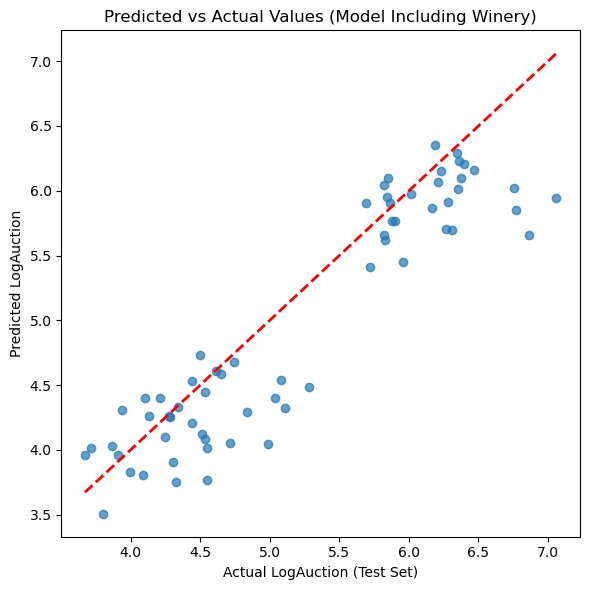

In [62]:
# Predicted vs Actual plot for the Winery model

wine_new_test = wine_new_test.copy()
wine_new_test["Pred_LogAuction"] = model_new.predict(wine_new_test)

plt.figure(figsize=(6,6))
plt.scatter(wine_new_test["LogAuction"], wine_new_test["Pred_LogAuction"], alpha=0.7)
plt.plot([wine_new_test["LogAuction"].min(), wine_new_test["LogAuction"].max()],
         [wine_new_test["LogAuction"].min(), wine_new_test["LogAuction"].max()],
         color="red", linestyle="--", linewidth=2)

plt.xlabel("Actual LogAuction (Test Set)")
plt.ylabel("Predicted LogAuction")
plt.title("Predicted vs Actual Values (Model Including Winery)")
plt.tight_layout()
plt.show()


### Interpretation of Predicted vs. Actual Plot (Winery Model)

The predicted vs. actual scatterplot provides a visual assessment of how 
well the model generalizes to unseen data. Points lying close to the 
45-degree reference line indicate accurate predictions.

For the Winery model, most points fall near the diagonal, showing that the 
model captures a substantial portion of the variation in LogAuction for 
the test set. This visual pattern aligns with the high OSR² value of 0.807, 
confirming that adding Winery significantly improves predictive accuracy 
relative to the baseline continuous model. 


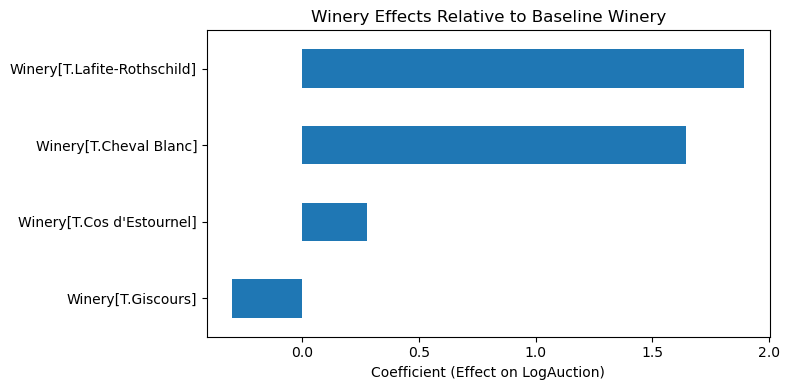

In [63]:
# Extract winery coefficients (categorical effects)
coef = model_new.params.filter(like="Winery[")

plt.figure(figsize=(8,4))
coef.sort_values().plot(kind='barh')
plt.xlabel("Coefficient (Effect on LogAuction)")
plt.title("Winery Effects Relative to Baseline Winery")
plt.tight_layout()
plt.show()


### Interpretation of the Model with Winery as a Categorical Variable

Including the Winery variable substantially improves the explanatory 
power of the model. The regression now explains **85.1%** of the variation 
in LogAuction on the training set (R² = 0.851), and the adjusted R² of 
0.834 indicates that the added complexity is warranted. This represents a 
meaningful improvement over the baseline continuous model.

### Winery Effects
Using `statsmodels` formula syntax, Winery is expanded into dummy 
variables, with one winery serving as the reference category. The results 
show large and statistically significant producer-specific effects:

- **Cheval Blanc (coef ≈ 1.6425, p < 0.001)**  
  Wines from Cheval Blanc sell at substantially higher prices compared to 
  the reference winery. Exponentiating the coefficient suggests roughly a 
  5.17x price premium (exp(1.6425) ≈ 5.17).

- **Lafite-Rothschild (coef ≈ 1.8941, p < 0.001)**  
  This winery has an even stronger premium, with prices approximately 
  6.65 times higher than the reference winery.

- **Cos d'Estournel (p ≈ 0.099)** and **Giscours (p ≈ 0.126)**  
  These coefficients are not statistically significant at the 5% level, 
  suggesting that their price differences relative to the reference winery 
  are not strong enough to be distinguished from noise.

These strong winery-specific effects align with historical pricing patterns 
in Bordeaux wines, where reputation and prestige drive substantial price 
variation.

### Climate and Aging Effects
The continuous predictors remain meaningful:

- **WinterRain (coef ≈ 0.0016, p < 0.001)**  
  A small but statistically significant positive effect.

- **HarvestRain (p = 0.664)**  
  No detectable effect in this dataset once winery and other variables 
  are included.

- **GrowTemp (coef ≈ 0.388, p < 0.001)**  
  Warmer growing seasons increase wine prices (~47% increase per degree, 
  based on exp(0.388) - 1).

- **Age (coef ≈ 0.0308, p < 0.001)**  
  Each additional year increases LogAuction by ~3.1% in price terms.

### Model Diagnostics
- Residual skew (0.667) and JB test p-value (0.044) suggest mild deviation 
  from normality, but not severe enough to invalidate the model.
- Durbin–Watson = 1.725 indicates mild positive autocorrelation, but within 
  acceptable limits for cross-sectional data.
- VIF and condition number indicate some remaining multicollinearity, likely
  due to winery-level differences tied to year and temperature.

### Out-of-Sample Performance
The model achieves an **OSR² of 0.807**, meaning it explains roughly **80.7%** 
of the variation in new, unseen wine data. This is a substantial improvement 
over the baseline continuous model (OSR² ≈ 0.747), indicating that winery 
identity adds meaningful predictive value.

### Overall Conclusion
Incorporating Winery dramatically enhances both model fit and predictive 
accuracy. The categorical effects capture substantial producer-level 
variation in wine pricing and elevate the model to one that generalizes 
exceptionally well to new data.
